# Imports and setup

In [1]:
#Import libraries


import rasterio
from rasterio import plot
from rasterio.plot import show
import numpy as np
import os
import math
import torch
import torch.nn as nn
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import  ListedColormap
import matplotlib

In [2]:
torch.random.manual_seed(0)
!nvidia-smi

Fri May  2 17:12:25 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.80                 Driver Version: 546.80       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P8              11W / 120W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [10]:
# Variables - Paths to Pastis Datasets, in folder PastisDatasets, in current directory
PATH_TO_CODE = '/PastisCode'
PATH_TO_PASTIS = 'C:\\Users\\Leonardo\\Documents\\Tesis\\Tesis2\\Imagenes\\PASTIS\\PASTIS'
PATH_TO_PASTISR = '/PastisDatasets/PastisR'
PATH_TO_PASTISR_pixel = '/PastisDatasets/PastisRPixel'

In [17]:
cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,20)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=21)

def get_rgb(x, batch_index=0, t_show=1):
    """Utility function to get a displayable rgb image 
    from a Sentinel-2 time series.
    """
    im = x['S2'][batch_index, t_show, [2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

def get_radar(x, batch_index=0, t_show=6, orbit='D'):
    """Utility function to get a displayable image 
    from a Sentinel-1 time series.
    """
    im = x['S1{}'.format(orbit)][batch_index, t_show].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

In [19]:

from PastisCode.dataloader import PASTIS_Dataset
from PastisCode.collate import pad_collate

dt = PASTIS_Dataset(PATH_TO_PASTIS, norm=True, target='instance')
# If you only need to evaluate semantic segmentation use target='semantic'

dl = torch.utils.data.DataLoader(dt, batch_size=2, collate_fn=pad_collate, shuffle=True)


Reading patch metadata . . .
Done.
Dataset ready.


In [32]:

# Loading a batch from the dataloader
(x, dates), y = dl.__iter__().__next__()

# x is a dictionary thay contains the Sentinel-2 time series
# in the 'S2' key, shape: B x T x C x H x W
print(x['S2'].shape)
# dates contains the observation dates of each image, shape: B x T
print(dates['S2'].shape)
# y contains the different ground truth annotations used for panoptic segmentation
(
    target_heatmap,
    instance_ids,
    pixel_to_instance_mapping,
    instance_bbox_size,
    object_semantic_annotation,
    pixel_semantic_annotation,
) = y.split((1, 1, 1, 2, 1, 1), dim=-1)


torch.Size([2, 61, 10, 128, 128])
torch.Size([2, 61])


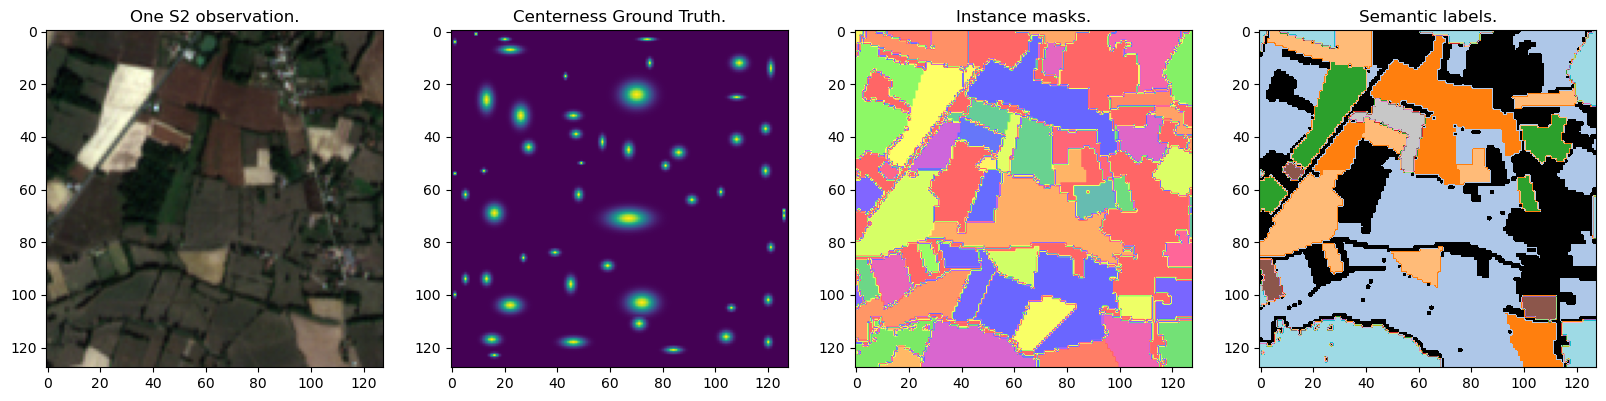

In [33]:
bid = 0 # Which element of the batch to plot

fix, axes = plt.subplots(1,4, figsize=(20,20))

axes[0].imshow(get_rgb(x, batch_index=bid))
axes[1].imshow(target_heatmap[bid].squeeze())
axes[2].imshow(instance_ids[bid].squeeze(), cmap='prism', alpha=.6)
axes[3].imshow(pixel_semantic_annotation[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('One S2 observation.')
axes[1].set_title('Centerness Ground Truth.')
axes[2].set_title('Instance masks.')
axes[3].set_title('Semantic labels.')

plt.show()

# Preprocessing of images

## Retrieving the splits

In [ ]:
# TODO: Retrieve the splits

## Splitting the dataset in training, val and test sets

In [ ]:
# TODO: Split the data into train, val, and test sets

# Segmentation model

## Base model (Unet) and steps

### Model

In [13]:
class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=1):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        def up_block(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )
        
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        
        self.bottleneck = conv_block(512, 1024)
        
        self.dec4 = up_block(1024, 512)
        self.dec4_conv = conv_block(1024, 512)
        self.dec3 = up_block(512, 256)
        self.dec3_conv = conv_block(512, 256)
        self.dec2 = up_block(256, 128)
        self.dec2_conv = conv_block(256, 128)
        self.dec1 = up_block(128, 64)
        self.dec1_conv = conv_block(128, 64)
        
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(nn.MaxPool2d(2)(enc1))
        enc3 = self.enc3(nn.MaxPool2d(2)(enc2))
        enc4 = self.enc4(nn.MaxPool2d(2)(enc3))
        
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))
        
        dec4 = self.dec4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4_conv(dec4)
        
        dec3 = self.dec3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3_conv(dec3)
        
        dec2 = self.dec2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2_conv(dec2)
        
        dec1 = self.dec1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1_conv(dec1)
        
        return self.final(dec1)

# Instantiate the model
unet_model = UNet(in_channels=4, out_channels=1)
print(unet_model)

UNet(
  (enc1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Conv2d(512, 1024, k

### Steps

## Training the model